In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from nexuskan import *
from nexuskan import KAN

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset** $y = x_0 x_1$ and orig. KAN multiplicaton

In [36]:
end_range = 1.0
start_range = 0.5
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y = x[:, 0] * x[:, 1]
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000],
    # 'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:],
    # 'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [41]:
model = KAN(width=[2, [0, 1], 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


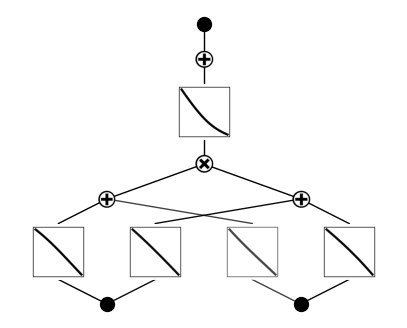

In [42]:
model(dataset['train_input'])
model.plot()

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

batch_size = 512 # dataset['train_input'].shape[0]
epochs = 600

for epoch in range(epochs):
    batches = dataset['train_input'].shape[0] // batch_size
    for batch_idx in range(batches):
        if batch_idx == batches - 1:
            indices = torch.arange(batch_idx * batch_size, dataset['train_input'].shape[0])
        else:
            indices = torch.arange(batch_idx * batch_size, (batch_idx + 1) * batch_size)
    
        batch_x = dataset['train_input'][indices]
        batch_y = dataset['train_label'][indices]
        
        outputs = model(batch_x)
        
        train_loss = criterion(outputs, batch_y)
        
        # reg = 0.0
        lamb = 0.0001
        l1_reg = sum(torch.norm(p, 1) for p in model.parameters())
        loss = train_loss + lamb * l1_reg
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        test_outputs = model(dataset['test_input'])
        test_loss = criterion(test_outputs, dataset['test_label'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, reg: {l1_reg:.4f}')

Epoch [10/600], Train Loss: 0.2543, Test Loss: 0.2407, reg: 60.5921
Epoch [20/600], Train Loss: 0.1508, Test Loss: 0.1417, reg: 62.1079
Epoch [30/600], Train Loss: 0.0750, Test Loss: 0.0687, reg: 62.5841
Epoch [40/600], Train Loss: 0.0317, Test Loss: 0.0300, reg: 62.5334
Epoch [50/600], Train Loss: 0.0245, Test Loss: 0.0254, reg: 62.5253
Epoch [60/600], Train Loss: 0.0261, Test Loss: 0.0266, reg: 62.3812
Epoch [70/600], Train Loss: 0.0244, Test Loss: 0.0248, reg: 62.0782
Epoch [80/600], Train Loss: 0.0241, Test Loss: 0.0247, reg: 61.8155
Epoch [90/600], Train Loss: 0.0242, Test Loss: 0.0247, reg: 61.6842
Epoch [100/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.6287
Epoch [110/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.5371
Epoch [120/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.4239
Epoch [130/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.3016
Epoch [140/600], Train Loss: 0.0241, Test Loss: 0.0246, reg: 61.1715
Epoch [150/600], Train Loss: 0.0241, Test L

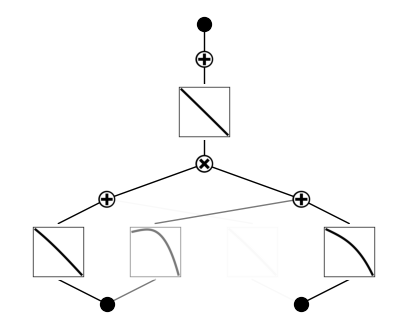

In [44]:
model.plot()

In [45]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

act_fun.0.coef tensor([[[ 5.6939e-04,  2.5393e-03,  1.6347e-03, -1.2068e-03, -1.1418e-04,
           3.4170e-02, -3.4417e-05, -3.2476e-05],
         [-1.1293e-04,  3.4233e-03, -7.3519e-04, -9.0660e-04, -1.9313e-04,
           5.9119e-02,  1.1446e-01, -6.0947e-04]],

        [[ 1.0559e-04,  1.6110e-03, -2.1293e-03,  9.0817e-05,  2.2824e-05,
           1.5920e-05,  9.2316e-05,  4.8331e-04],
         [-1.4326e-03, -5.5596e-04, -1.6931e-03,  3.0028e-04, -4.4244e-04,
           7.2981e-02,  1.4132e-01, -3.5366e-04]]], device='cuda:0')
act_fun.0.scale_base tensor([[-0.3606, -0.0436],
        [-0.0034, -0.1377]], device='cuda:0')
act_fun.0.scale_sp tensor([[0.2542, 0.2551],
        [0.0211, 0.3764]], device='cuda:0')
act_fun.1.coef tensor([[[ 3.1180e-05, -4.1853e-03,  2.4057e-01,  5.0765e-01,  3.1301e-01,
           2.7166e-01,  5.4807e-04, -8.8915e-04]]], device='cuda:0')
act_fun.1.scale_base tensor([[-0.0823]], device='cuda:0')
act_fun.1.scale_sp tensor([[1.4019]], device='cuda:0')
symbolic

saving model version 0.1


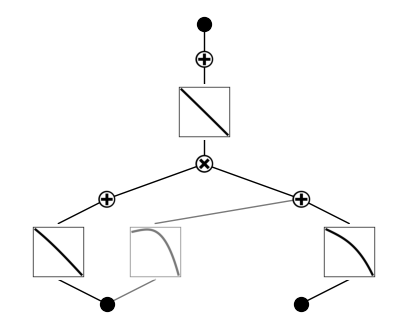

In [46]:
model = model.prune()
model.plot()

fixing (0,0,0) with x^2, r2=0.9999828934669495, c=2
fixing (0,0,1) with exp, r2=0.9896756410598755, c=2
fixing (0,1,0) with 0
fixing (0,1,1) with exp, r2=0.9999069571495056, c=2
fixing (1,0,0) with exp, r2=1.0000004768371582, c=2
saving model version 0.2


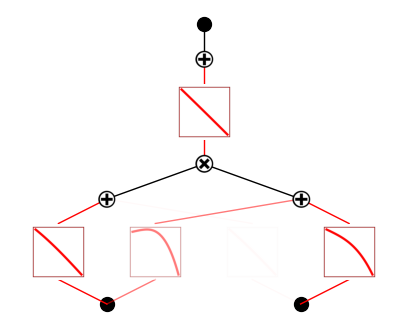

In [47]:
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
model.plot()

In [48]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.7367 - 0.1704*exp(2.668*(0.0863 - 0.0011*(-9.1526*x_1 - 8.7832)**2)*(-0.0013*exp(3.5558*x_2) - 0.0169))

# **Dataset** $y = x_0 x_1$ and nexusKAN multiplicaton

In [ ]:
end_range = 1.0
start_range = 0.5
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
# y = torch.sin(2 * torch.pi * x[:, 0]) + torch.sin(2 * torch.pi * x[:, 1])
y = x[:, 0] * x[:, 1]
# y_class = torch.where(y > 0.5, 1.0, 0.0)
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000],
    # 'train_label': y_class[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:],
    # 'test_label': y_class[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape